# How does different socioeconomical factor affect the number of close friends

In [2]:
import pandas as pd
from statsmodels.formula.api import ols
import numpy as np
import plotly.express as px

df = pd.read_csv('https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv', low_memory=False)
df = df[(df['REMOVE_case']=='No') & (df['SURVEY_collection_year']==2022)]

df

,UNIQUE_id,UNIQUE_num_records,ELIGIBLE_consent,GEO_residence_canada,GEO_province,DEMO_age,DEMO_gender,DEMO_identity_vetrans,DEMO_identity_indigenous,DEMO_identity_lgbtq,...,PSYCH_body_self_image_questionnaire_height_dissatisfaction_score,PSYCH_body_self_image_questionnaire_fatness_evaluation_score,PSYCH_body_self_image_questionnaire_negative_affect_score,PSYCH_body_self_image_questionnaire_social_dependence_score,PSYCH_big_five_inventory_agreeable_score,PSYCH_big_five_inventory_conscientious_score,PSYCH_big_five_inventory_extraverted_score,PSYCH_big_five_inventory_neurotic_score,PSYCH_big_five_inventory_open_score,REMOVE_case
0,cscs_00001,1,Yes,Yes,British Columbia,71.0,Non-binary,NaN,NaN,"Sexual or gender minorities (e.g., LGBTQ2+)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1,cscs_00002,1,Yes,Yes,Ontario,69.0,Woman,NaN,NaN,Not Selected,...,3.0,8.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,No
2,cscs_00003,1,Yes,Yes,Quebec,56.0,Woman,NaN,NaN,Not Selected,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5,cscs_00007,1,Yes,Yes,Ontario,55.0,Woman,NaN,NaN,Not Selected,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
7,cscs_00009,1,Yes,Yes,Ontario,52.0,Woman,NaN,NaN,Not Selected,...,15.0,15.0,15.0,11.0,NaN,NaN,NaN,NaN,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11422,cscs_11804,1,Yes,Yes,Ontario,50.0,Woman,NaN,NaN,"Sexual or gender minorities (e.g., LGBTQ2+)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
11423,cscs_11806,1,Yes,Yes,British Columbia,64.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
11424,cscs_11807,1,Yes,Yes,Ontario,68.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
11427,cscs_11810,1,Yes,Yes,British Columbia,36.0,Man,NaN,NaN,Not Selected,...,NaN,NaN,NaN,NaN,32.0,37.0,31.0,NaN,38.0,No


Selecting the variables of interest.

In [3]:
research_question1 = df[['CONNECTION_social_num_close_friends', 'CONNECTION_social_time_friends_p7d', 'COVID_vaccinated', 'DEMO_household_income', 'CONNECTION_preference_time_friends']].dropna()
research_question1

,CONNECTION_social_num_close_friends,CONNECTION_social_time_friends_p7d,COVID_vaccinated,DEMO_household_income,CONNECTION_preference_time_friends
1,5.0,4.0,"Yes, three or more doses","$70,000 to $79,999",6.0
2,5.0,9.0,"Yes, three or more doses","Under $5,000",5.0
5,7.0,3.0,"Yes, three or more doses",Presented but no response,2.0
7,0.0,0.0,"Yes, three or more doses","$10,000 to $14,999",0.0
11,4.0,10.0,No,"$50,000 to $59,999",8.0
...,...,...,...,...,...
11405,6.0,30.0,No,"$15,000 to $19,999",30.0
11414,1.0,2.0,"Yes, two doses","$50,000 to $59,999",4.0
11421,0.0,0.0,"Yes, three or more doses","$140,000 to $149,999",0.0
11422,2.0,1.0,No,"$10,000 to $14,999",3.0


### Data processing
1. Cleans up data by removing data with "Presented but no response" in either `COVID_vaccinated` or `DEMO_household_income`.
2. Turns `DEMO_household_income` into a binary indicator `True` for vaccinated regardless of how many dose and `False` for not vaccinated.
3. Organize `DEMO_household_income` into 3 categories `low`, `middle`, and `high` income households based on thresholds in household income.

In [4]:
research_question1 = research_question1[(research_question1['COVID_vaccinated'] != 'Presented but no response') & (research_question1['DEMO_household_income'] != 'Presented but no response')]
research_question1['COVID_vaccinated'] = research_question1['COVID_vaccinated'] != 'No'


def classify(row: str):
    row = row.replace(',', '').replace('$', '')
    start, end = -1, -1
    if 'Under' in row:
        start, end = 0, int(row.replace('Under', ''))
    elif 'or more' in row:
        start, end = int(row.replace('or more', '')), float('inf')
    else:
        start, end = map(int, row.split(' to '))
    
    if end <= 29999:
        return 'low'
    elif 30000 <= start and end <= 149999:
        return 'middle'
    elif start >= 150000:
        return 'high'

research_question1['income_class'] = research_question1['DEMO_household_income'].apply(classify)
research_question1

/var/folders/zy/5v6mg52s43vb8v5jss7hmh7w0000gn/T/ipykernel_19918/732186326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  research_question1['COVID_vaccinated'] = research_question1['COVID_vaccinated'] != 'No'
/var/folders/zy/5v6mg52s43vb8v5jss7hmh7w0000gn/T/ipykernel_19918/732186326.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  research_question1['income_class'] = research_question1['DEMO_household_income'].apply(classify)


,CONNECTION_social_num_close_friends,CONNECTION_social_time_friends_p7d,COVID_vaccinated,DEMO_household_income,CONNECTION_preference_time_friends,income_class
1,5.0,4.0,True,"$70,000 to $79,999",6.0,middle
2,5.0,9.0,True,"Under $5,000",5.0,low
7,0.0,0.0,True,"$10,000 to $14,999",0.0,low
11,4.0,10.0,False,"$50,000 to $59,999",8.0,middle
15,5.0,3.0,True,"$150,000 to $159,999",5.0,high
...,...,...,...,...,...,...
11405,6.0,30.0,False,"$15,000 to $19,999",30.0,low
11414,1.0,2.0,True,"$50,000 to $59,999",4.0,middle
11421,0.0,0.0,True,"$140,000 to $149,999",0.0,middle
11422,2.0,1.0,False,"$10,000 to $14,999",3.0,low


#### 1. Does being vaccinated affect the amount of time socializing with friends?
Rationale: Since not being vaccinated generally have a negative connotation, does it make people less willing to interact with you?

Method of Investigation: Permutation testing<br>
Independent Variable: Whether they are vaccinated or not (`COVID_vaccinated`)<br>
Dependent Variable: Time spent socializing with friends in the past 7 days (`CONNECTION_social_time_friends_p7d`)

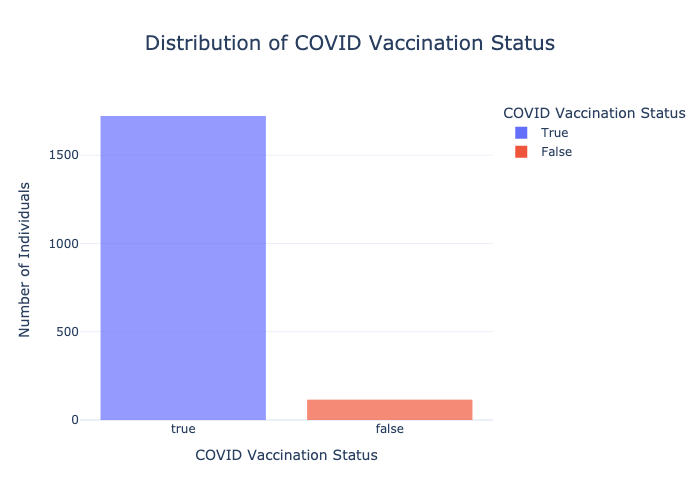

In [5]:
part_1 = research_question1[['COVID_vaccinated', 'CONNECTION_social_time_friends_p7d']].copy()

bar_plot = px.bar(
    part_1, x='COVID_vaccinated', title="Distribution of COVID Vaccination Status",
    labels={
        'COVID_vaccinated': 'COVID Vaccination Status', 
        'count': 'Number of Individuals'
    },
    color='COVID_vaccinated',
)

bar_plot.update_layout(
    title=dict(font=dict(size=20), x=0.5),
    xaxis_title="COVID Vaccination Status",
    yaxis_title="Number of Individuals",
    xaxis=dict(tickangle=0),
    template='plotly_white',
)

bar_plot.update_traces(dict(marker_line_width=0))

bar_plot.show(renderer='png')

Evidently the majority of people are vaccinated.

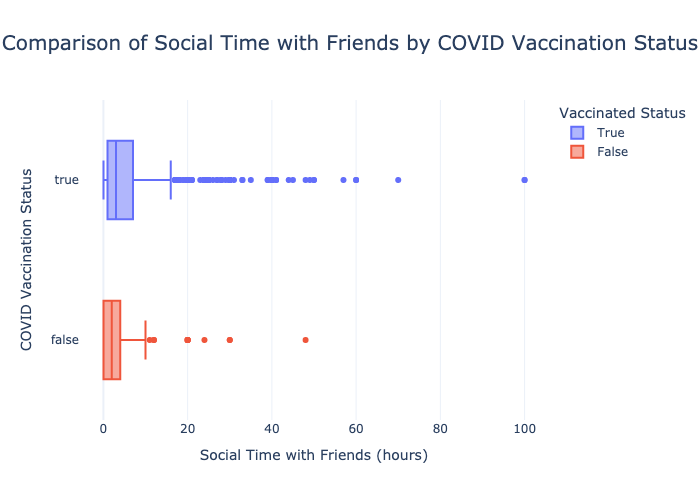

In [6]:
box_plot = px.box(
    part_1,
    y='COVID_vaccinated', 
    x='CONNECTION_social_time_friends_p7d',
    color='COVID_vaccinated',
    title="Comparison of Social Time with Friends by COVID Vaccination Status",
    labels={
        'COVID_vaccinated': 'COVID Vaccination Status',
        'CONNECTION_social_time_friends_p7d': 'Social Time with Friends (past 7 days)'
    },
)

box_plot.update_layout(
    title=dict(font=dict(size=20), x=0.5),
    yaxis_title="COVID Vaccination Status",
    xaxis_title="Social Time with Friends (hours)",
    template="plotly_white",
    legend_title="Vaccinated Status",
)

box_plot.show(renderer='png')

It seems like there is a difference in the distribution of time spent socializing with friends...

Null hypothesis: $H_0: \text{Being vaccinated or not doesn't matter.}$

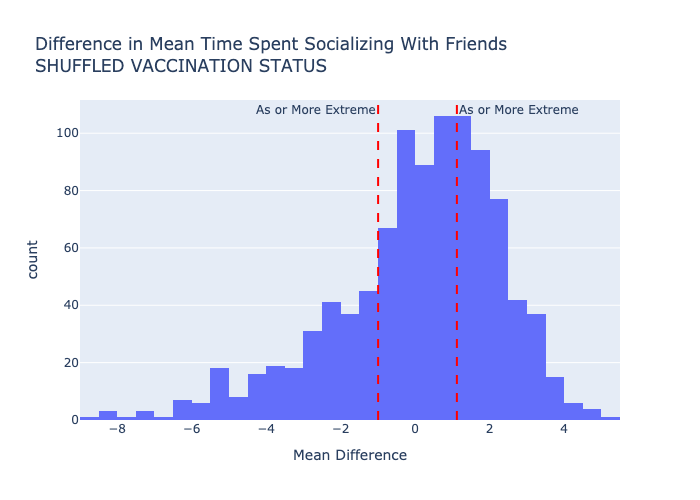

Observed Mean Time Difference: 1.1201479308026165
P-Value:  0.614


In [7]:
observed_difference = part_1.groupby('COVID_vaccinated')['CONNECTION_social_time_friends_p7d'].mean().diff().values[1]

n = 1000
simulations_1 = np.zeros(n)
for i in range(n):
    part_1['shuffled_vaccinated'] = part_1['COVID_vaccinated'].sample(frac=1, replace=False).reset_index(drop=True)
    simulations_1[i] = part_1.groupby('shuffled_vaccinated')['CONNECTION_social_time_friends_p7d'].mean().diff().values[1]

hist = px.histogram(
    simulations_1, nbins=30,
    title="Difference in Mean Time Spent Socializing With Friends<br>SHUFFLED VACCINATION STATUS",
    labels={'value': 'Mean Difference'},
)

hist.add_vline(
    x=observed_difference, 
    line_color="red", 
    line_dash="dash", 
    annotation_text="As or More Extreme",
    annotation_position="top right"
)
hist.add_vline(
    x=2*simulations_1.mean()-observed_difference, 
    line_color="red", 
    line_dash="dash",
    annotation_text="As or More Extreme",
    annotation_position="top left"
)

hist.update_layout(showlegend=False)

hist.show(renderer='png')

print(f'Observed Mean Time Difference: {observed_difference}')
print("P-Value: ", (abs(simulations_1-simulations_1.mean()) >= abs(simulations_1.mean()-observed_difference)).sum()/n)

No evidence against the null hypothesis.

#### 2. Does household income affect the number of time spent socializing with friends?
Rationale: How common are gold diggers?

Predictor Variable: Low middle or high income households (`income_class`) <br>
Outcome Variable: Time spent socializing with friends in the past 7 days (`CONNECTION_social_time_friends_p7d`)

Method of Investigation: Linear Regression

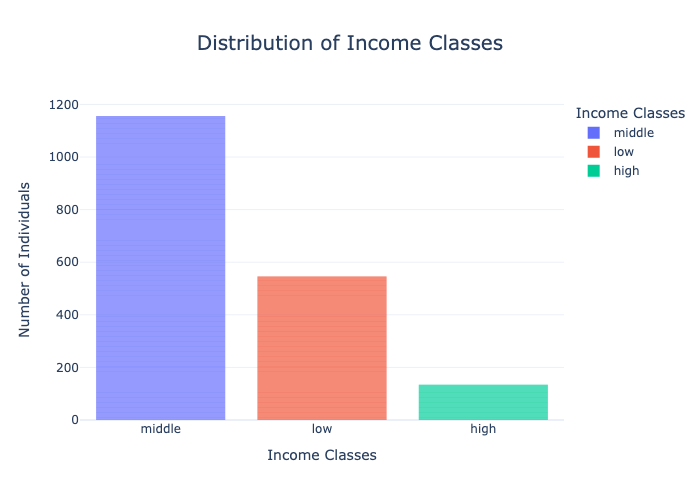

In [5]:
part_2 = research_question1[['income_class', 'CONNECTION_social_time_friends_p7d']].copy()

bar_2 = px.bar(
    part_2, x='income_class', 
    title="Distribution of Income Classes",
    labels={
        'income_class': 'Income Classes', 
        'count': 'Number of Individuals'
    },
    color='income_class',
)

bar_2.update_layout(
    title=dict(font=dict(size=20), x=0.5),
    xaxis_title="Income Classes",
    yaxis_title="Number of Individuals",
    xaxis=dict(tickangle=0),
    template='plotly_white',
)

bar_2.update_traces(dict(marker_line_width=0))

bar_2.show(renderer='png')

Most people are middle income households as expected...

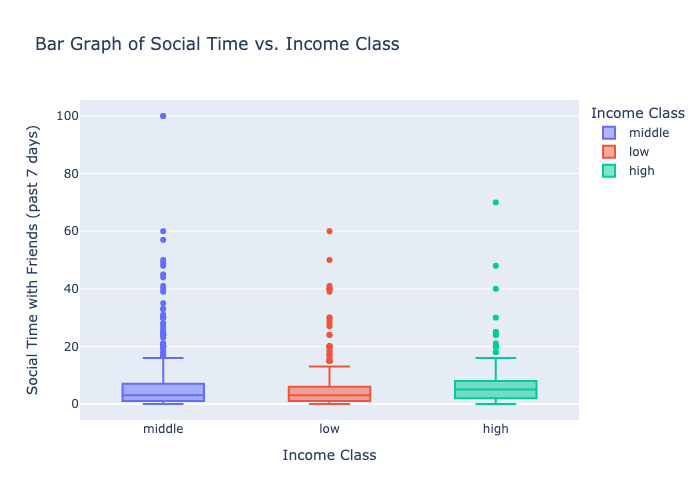

In [6]:
box_2 = px.box(
    part_2, 
    x='income_class', 
    y='CONNECTION_social_time_friends_p7d', 
    color='income_class',  # Different colors for categories
    title="Bar Graph of Social Time vs. Income Class",
    labels={
        'income_class': 'Income Class',
        'CONNECTION_social_time_friends_p7d': 'Social Time with Friends (past 7 days)'
    },
)

box_2.show(renderer='png')

Seems like the social time distribution are similar...

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     CONNECTION_social_time_friends_p7d   R-squared:                       0.005
Model:                                            OLS   Adj. R-squared:                  0.004
Method:                                 Least Squares   F-statistic:                     4.791
Date:                                Sat, 30 Nov 2024   Prob (F-statistic):            0.00841
Time:                                        23:29:23   Log-Likelihood:                -6386.6
No. Observations:                                1836   AIC:                         1.278e+04
Df Residuals:                                    1833   BIC:                         1.280e+04
Df Model:                                           2                                         
Covariance Type:                            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7.0821      0.678     10.444      0.000       5.752       8.412
income_class[T.low]       -2.2927      0.757     -3.030      0.002      -3.777      -0.809
income_class[T.middle]    -1.6003      0.716     -2.234      0.026      -3.005      -0.195
==============================================================================
Omnibus:                     1741.851   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            89745.659
Skew:                           4.420   Prob(JB):                         0.00
Kurtosis:                      36.091   Cond. No.                         8.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

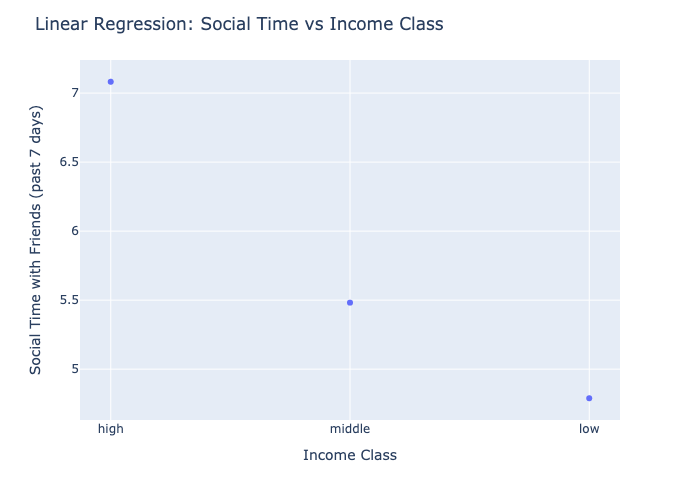

In [7]:
model = ols('CONNECTION_social_time_friends_p7d ~ income_class', part_2).fit()
display(model.summary())

lin_reg = px.scatter(
    pd.DataFrame(
        data={
            'x_i':['high', 'middle', 'low'], 
            'y_hat_i':[
                model.params['Intercept'],
                model.params['Intercept'] + model.params['income_class[T.middle]'],
                model.params['Intercept'] + model.params['income_class[T.low]']
            ]
        }
    ), x='x_i', y='y_hat_i'
)

lin_reg.update_layout(
    title="Linear Regression: Social Time vs Income Class",
    xaxis_title="Income Class",
    yaxis_title="Social Time with Friends (past 7 days)"
)

lin_reg.show(renderer='png')

Seems like the richer you are the more time you will spend socializing with friends, and the p-values are significant, so is it because of the gold diggers or is it because of something else...

### 3. Is the social time with friends affected by the number of close friends and your prefered amount of time spent with friends?

Rationale: I think that is pretty selfexplanatory.

Predictor Variables: Number of close friends (`CONNECTION_social_num_close_friends`), and Ideally, how many hours per week would you like to spend socializing with each of the following groups? - Friends (`CONNECTION_preference_time_friends`) <br>
Outcome Variable: Time spent socializing with friends in the past 7 days (`CONNECTION_social_time_friends_p7d`)

Method of Linear Regression: Multiple linear regression

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     CONNECTION_social_time_friends_p7d   R-squared:                       0.260
Model:                                            OLS   Adj. R-squared:                  0.258
Method:                                 Least Squares   F-statistic:                     214.1
Date:                                Sun, 01 Dec 2024   Prob (F-statistic):          4.84e-119
Time:                                        00:23:29   Log-Likelihood:                -6115.5
No. Observations:                                1836   AIC:                         1.224e+04
Df Residuals:                                    1832   BIC:                         1.226e+04
Df Model:                                           3                                         
Covariance Type:                            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  2.0718      0.297      6.965      0.000       1.488       2.655
CONNECTION_preference_time_friends                                         0.1935      0.021      9.137      0.000       0.152       0.235
CONNECTION_social_num_close_friends                                        0.2537      0.059      4.308      0.000       0.138       0.369
CONNECTION_preference_time_friends:CONNECTION_social_num_close_friends     0.0156      0.003      4.731      0.000       0.009       0.022
==============================================================================
Omnibus:                     1851.992   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           223870.199
Skew:                           4.536   Prob(JB):                         0.00
Kurtosis:                      56.330   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

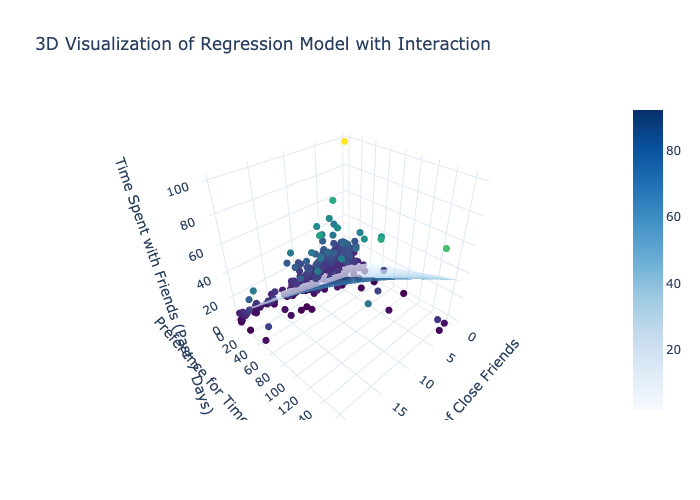

0.25957733463846566


In [8]:
import plotly.graph_objects as go

part_3 = research_question1[['CONNECTION_social_num_close_friends', 'CONNECTION_social_time_friends_p7d', 'CONNECTION_preference_time_friends']].copy()

model_2 = ols('CONNECTION_social_time_friends_p7d ~ CONNECTION_preference_time_friends * CONNECTION_social_num_close_friends', part_3).fit()
display(model_2.summary())

X_pred = np.linspace(part_3['CONNECTION_social_num_close_friends'].min(), 
                     part_3['CONNECTION_social_num_close_friends'].max(), 
                     50)
Y_pred = np.linspace(part_3['CONNECTION_preference_time_friends'].min(), 
                     part_3['CONNECTION_preference_time_friends'].max(), 
                     50)
X_mesh, Y_mesh = np.meshgrid(X_pred, Y_pred)

# Generate predicted Z values using the model
Z_pred = model_2.predict({
    'CONNECTION_social_num_close_friends': X_mesh.ravel(),
    'CONNECTION_preference_time_friends': Y_mesh.ravel()
}).to_numpy().reshape(X_mesh.shape)  # Convert to NumPy and reshape

# Create the 3D scatter plot
scatter = go.Scatter3d(
    x=part_3['CONNECTION_social_num_close_friends'], 
    y=part_3['CONNECTION_preference_time_friends'], 
    z=part_3['CONNECTION_social_time_friends_p7d'], 
    mode='markers',
    marker=dict(size=4, color=part_3['CONNECTION_social_time_friends_p7d'], colorscale='Viridis'),
    name='Observed Data'
)

# Create the regression surface
surface = go.Surface(
    x=X_pred, 
    y=Y_pred, 
    z=Z_pred, 
    colorscale='Blues', 
    opacity=0.7, 
    name='Regression Surface'
)

# Combine plots
fig = go.Figure(data=[scatter, surface])

# Update layout
fig.update_layout(
    title="3D Visualization of Regression Model with Interaction",
    scene=dict(
        xaxis_title='Number of Close Friends',
        yaxis_title='Preference for Time with Friends',
        zaxis_title='Time Spent with Friends (Past 7 Days)'
    ),
    template='plotly_white',
    showlegend=False
)

fig.show(renderer='png')
print(model_2.rsquared)

By looking at the coefficients, more close friends and willing to spend more time with friends results in more time spend socializing with friends, and the p-values look good, as expected?